# TUTORIAL 2: Depletion and material manipulation

In [12]:
# Import modules
import cerberus
from cerberus.solvers import CodeInput, Solver
import shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import RegularPolygon, Circle
import pandas as pd

In [13]:
# Functions definition

# To make our life easier, we can create a routine that does the "get_transferrable" and "communicate" together.
def get_values(name, serpent_instance, input_variable=False):
    if input_variable and 'sss_iv_' not in name: # you can get rid of "sss_ov" from now on
        transferrable_name = 'sss_iv_'+name
    else:
        transferrable_name = 'sss_ov_'+name
    transferrable = serpent_instance.get_transferrable(transferrable_name)
    if not input_variable: # we should NOT communicate this when just monitoring input variables, Serpent does not know this information
        transferrable.communicate() # receive
    return transferrable

# For input variables, we can set values of value_vec
def set_values(name, values, serpent_instance): # you can only set input variables so no need to use sss_ov
    if 'sss_iv_' not in name: # you can get rid of "sss_ov" from now on
        transferrable_name = 'sss_iv_'+name
    transferrable = serpent_instance.get_transferrable(transferrable_name)
    transferrable.value_vec = np.array(values)
    transferrable.communicate() # send
    return transferrable

# Function to plot hexagonal lattice
def plot_hex(hexagonal_data, radius_over_pitch=None, hide_zeros=False, label=None): # if we give rod radii, it will render circles and not hexagons in the hexagonal lattice
    h = 1/2
    a = 2/np.sqrt(3)*h
    x0 = -3/2*h*(hexagonal_data.shape[1]-1)
    y0 = 1.5*a*(hexagonal_data.shape[1]-1)/2
    coordinates = [[], []]     
    for ind_line in range(hexagonal_data.shape[0]):
        coordinates[0].append([])
        coordinates[1].append([])
        x_inc = x0 + h*2 * ind_line
        y_inc = y0
        for ind_col in range(hexagonal_data.shape[1]):
            coordinates[0][-1].append(x_inc)
            coordinates[1][-1].append(y_inc)
            x_inc += h
            y_inc -= a*1.5
    fig, ax = plt.subplots()
    patches = []
    array = []
    for ind_line in range(hexagonal_data.shape[0]):
        for ind_col in range(hexagonal_data.shape[1]):
            if not hide_zeros or hexagonal_data[ind_line, ind_col] != 0:
                if not radius_over_pitch: # Make hexagon
                    patches.append(RegularPolygon((coordinates[0][ind_line][ind_col], coordinates[1][ind_line][ind_col]), 6, radius=a, orientation=0, edgecolor='k'))
                else:
                    patches.append(Circle((coordinates[0][ind_line][ind_col], coordinates[1][ind_line][ind_col]), radius=radius_over_pitch))
                array.append(hexagonal_data[ind_line, ind_col])
    p = PatchCollection(patches, cmap='plasma')
    p.set_array(array)
    ax.add_collection(p)
    ax.axis(False)
    fig.colorbar(p, shrink=0.5, label=label)
    # Set x and y limits
    x_min, x_max = np.min(coordinates[0])-a, np.max(coordinates[0])+a
    y_min, y_max = np.min(coordinates[1])-a, np.max(coordinates[1])+a
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.gca().set_aspect('equal')
    plt.tight_layout()

## 1) Simple depletion calculation

In [14]:
# Start Serpent with another input corresponding to the depletion input

serpent_path = '/home/yvrob/Serpent_Cerberus/Serpent_2.2.0_pbed/sss2'
list_input_files = ['input_depletion', 'input.mvol'] # list all file paths used in Serpent 
ncores = 20 # how many cores to use with openmpi
# Create serpent instance
serpent = Solver("Serpent", serpent_path, f"-port -omp {ncores}".split()) # port is for telling Serpent it is coupled with Cerberus
serpent.input = CodeInput(list_input_files, main_input_idx=0) # first ("0") input file is the main file
serpent.initialize()

Creating working directory and input for Serpent...
OK.
Initializing Serpent for socket communication
OK.
Obtaining field names and variable definitions for Serpent
Solver Serpent can accept 0 fields:

Solver Serpent can provide 0 fields:

Solver Serpent can provide 690 variable(s):
Name                                               Data Type  Number of Values    
sss_ov_DET_detlatfuel                              float64    49                  
sss_ov_DET_detlatfuel_rel_unc                      float64    49                  
sss_ov_DET_EnergyDetector                          float64    500                 
sss_ov_DET_EnergyDetector_rel_unc                  float64    500                 
sss_ov_DET_EnergyDetectorfuel                      float64    500                 
sss_ov_DET_EnergyDetectorfuel_rel_unc              float64    500                 
sss_ov_DET_EnergyDetectorgraf                      float64    500                 
sss_ov_DET_EnergyDetectorgraf_rel_unc              f

In [15]:
# We always need to set an initial time before to start depletion (WARNING: everything is in seconds in Cerberus)
current_time = 0
step = 0
serpent.set_current_time(current_time)

# Run a first transport step (not necessary but always nice to see first state)
set_values('neutrons_per_cycle', [2000], serpent)
# We will artificially increase the power to get faster burnup
set_values('norm_power', [25e6], serpent)

serpent.solve()
keff = get_values('ANA_KEFF', serpent).value_vec
keff_rel_unc = get_values('ANA_KEFF_rel_unc', serpent).value_vec
keff_unc = keff*keff_rel_unc
print(f'keff = {keff[0]:.5f} +/- {keff_unc[0]*1e5:.0f} pcm')

# Keep track of fuel burnup
burnup_history = dict()
burnup_history[step] = get_values('material_fuel_salt_burnup', serpent).value_vec

# Create a table which will be used to keep power history
powers_history = pd.DataFrame(index=range(7*7)) # each row is a lattice tally
powers_history.loc[:, step] = get_values('DET_detlatfuel', serpent).value_vec

# Create a table which will be used to keep fuel composition history
nuclides_inventory = get_values('inventory', serpent).value_vec # only keep track of the inventory
fuel_history = pd.DataFrame(index=nuclides_inventory) # each row is a lattice tally
fuel_history.loc[:, step] = get_values('composition_fuel_salt_inventory', serpent).value_vec

# Create two tables which will be used to keep neutron spectrum history
spectrum_history = pd.DataFrame(index=range(len(midE))) # each row is an energy bin
spectrum_history.loc[:, step] = get_values("DET_EnergyDetectorfuel", serpent).value_vec # read from Serpent
spectrum_history.loc[:, step] /= spectrum_history.loc[:, step].max() # normalize

#Print powers (at least the 25 highest, to show empty lattice slots as well)
powers_history.sort_values(0)[::-1].head(25)

keff = 1.00369 +/- 190 pcm


NameError: name 'midE' is not defined

In [ ]:
fuel_history.sort_values(0)[::-1].head(25)

,0
922380,0.000231
922350,0.000046
380890,0.000000
541330,0.000000
892270,0.000000
892260,0.000000
892250,0.000000
922330,0.000000
420990,0.000000
380900,0.000000


In [ ]:
time_step_days = 20 # days
DAYS = 24*60*60

# Run depletion once
current_time += time_step_days*DAYS # increment time
step += 1
serpent.advance_to_time(current_time) # runs one transport step and burn
powers_history.loc[:, step] = get_values('DET_detlatfuel', serpent).value_vec # add to table
spectrum_history.loc[:, step] = get_values("DET_EnergyDetectorfuel", serpent).value_vec # read from Serpent
spectrum_history.loc[:, step] /= spectrum_history.loc[:, step].max() # normalize

In [ ]:
# # If not pcc 0 (i.e, if we are using predictor/corrector), we should add a "correct" step
# # Warning: this erases the detectors data (which is tallied before the corrector anyway), so process it before as done here
serpent.correct() # run new transport step and correct burn
fuel_history.loc[:, step] = get_values('composition_fuel_salt_inventory', serpent).value_vec
burnup_history[step] = get_values('material_fuel_salt_burnup', serpent).value_vec

In [ ]:
# Repeat that 5 times (so 7 time steps, including the first transport and first burnup step)
for i in range(5):
    current_time += time_step_days*DAYS # increment time
    step += 1
    serpent.advance_to_time(current_time) # runs one transport step and burn
    powers_history.loc[:, step] = get_values('DET_detlatfuel', serpent).value_vec # add to table
    spectrum_history.loc[:, step] = get_values("DET_EnergyDetectorfuel", serpent).value_vec # read from Serpent
    spectrum_history.loc[:, step] /= spectrum_history.loc[:, step].max() # normalize
    serpent.correct() # run new transport step and correct burn
    fuel_history.loc[:, step] = get_values('composition_fuel_salt_inventory', serpent).value_vec
    burnup_history[step] = get_values('material_fuel_salt_burnup', serpent).value_vec


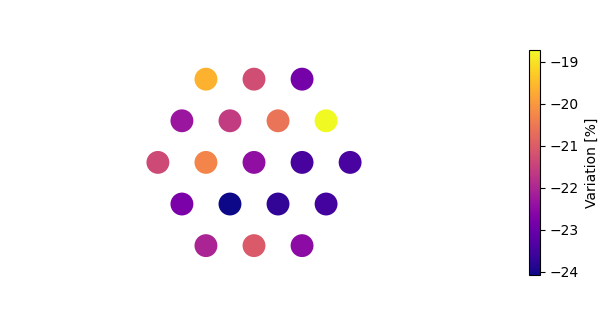

In [ ]:
plot_hex((100*(powers_history[6]-powers_history[0])/powers_history[0]).values.reshape(7, -1), radius_over_pitch=5/21, hide_zeros=True, label='Variation [%]')
# The decrease that we see here is because the material "fuel_salt2" which does not burn in the model takes more and more imporance

Text(0.5, 1.0, 'Last step')

<Figure size 640x480 with 0 Axes>

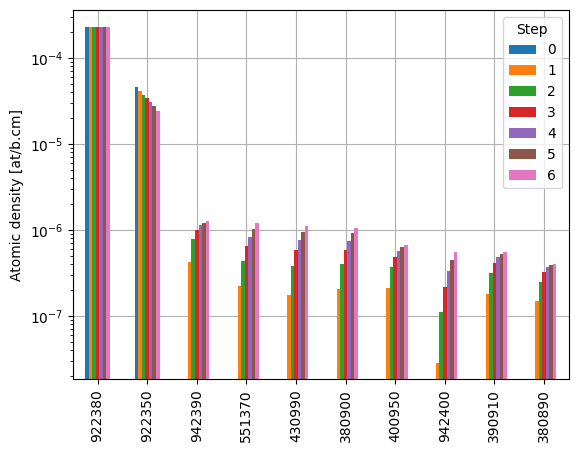

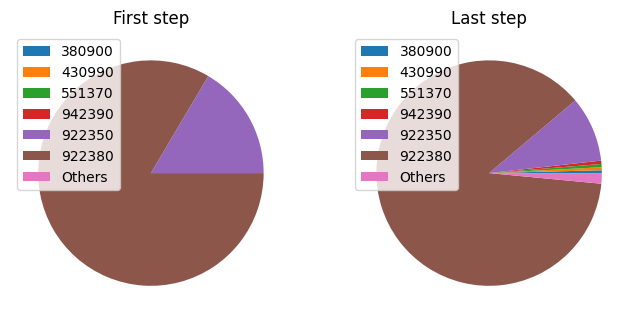

In [ ]:
# Plot top 10 isotopes evolution with the steps
plt.figure()
fuel_history.sort_values(6, ascending=False).iloc[:10].plot(kind='bar', logy=True)
plt.legend(title='Step')
plt.grid()
plt.gca().set_axisbelow(True)
plt.ylabel('Atomic density [at/b.cm]')

# Plot initial and final isotopic repartition
significant = (fuel_history.iloc[:,-1]>1e-6) # Everything else than isotopes that have a concentration of >1e-6 is label as others
fuel_history_short = fuel_history[significant].sort_values(6).copy() # Get values
fuel_history_short.loc['Others'] = fuel_history[~significant].sum(axis=0) # Add the Others row
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plt.sca(axs[0])
fuel_history_short.plot(y=0, kind='pie', labeldistance=None, ylabel='', ax=axs[0]) # Plot first step
plt.title('First step')
plt.sca(axs[1])
fuel_history_short.plot(y=6, kind='pie', labeldistance=None, ylabel='', ax=axs[1]) # Plot last step
plt.title('Last step')


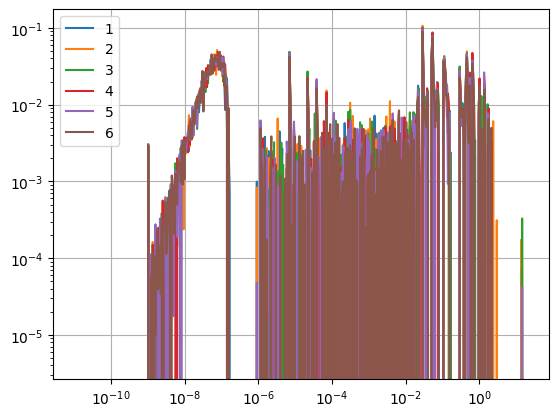

In [ ]:
# Plot spectrum evolution
plt.plot(midE, spectrum_history.diff().iloc[:,1:], label=spectrum_history.columns[1:]) 
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.gca().set_axisbelow(True)
plt.legend()

## 2) Manipulating materials

In [ ]:
# # We are going to restart Serpent and simply remove Xenon from the fuel_salt material

# We can set Cerberus' verbosity so that it does not print messages ("0")
cerberus.LOG.set_verbosity(0)

list_input_files = ['input_depletion', 'input.mvol'] # list all file paths used in Serpent 
ncores = 20 # how many cores to use with openmpi
# Create serpent instance
serpent = Solver("Serpent", serpent_path, f"-port -omp {ncores}".split()) # port is for telling Serpent it is coupled with Cerberus
serpent.input = CodeInput(list_input_files, main_input_idx=0) # first ("0") input file is the main file
serpent.initialize()

# We always need to set an initial time before to start depletion (WARNING: everything is in seconds in Cerberus)
current_time = 0
step = 0
serpent.set_current_time(current_time)

# Run a first transport step (not necessary but always nice to see first state)
set_values('neutrons_per_cycle', [target_neutrons], serpent)
# We will artificially increase the power to get faster burnup
set_values('norm_power', [25e6], serpent)

serpent.solve()

# Keep track of keff
keff_hist = dict()
keff = get_values('ANA_KEFF', serpent).value_vec
keff_rel_unc = get_values('ANA_KEFF_rel_unc', serpent).value_vec
keff_unc = keff*keff_rel_unc
keff_hist[step] = keff
print(f'keff = {keff[0]:.5f} +/- {keff_unc[0]*1e5:.0f} pcm')

# Create a table which will be used to keep fuel composition history
nuclides_inventory = get_values('inventory', serpent).value_vec # only keep track of the inventory
nuclides_whole_list = get_values('composition_fuel_salt_zai', serpent).value_vec # get full list of nuclides for changing composition

fuel_history = pd.DataFrame(index=nuclides_inventory) # each column is a lattice tally
fuel_history.loc[:, step] = get_values('composition_fuel_salt_inventory', serpent).value_vec

spectrum_history_noXe = pd.DataFrame(index=range(len(midE))) # each row is an energy bin
spectrum_history_noXe.loc[:, step] = get_values("DET_EnergyDetectorfuel", serpent).value_vec # read from Serpent
spectrum_history_noXe.loc[:, step] /= spectrum_history_noXe.loc[:, step].max() # normalize

# Repeat that 6 times
for i in range(6):
    # Remove Xenon
    current_fuel_composition = get_values('composition_fuel_salt_adens', serpent).value_vec # we first extract the fuel composition, "sss_ov"
    new_fuel_composition = current_fuel_composition.copy() # create new fuel composition
    new_fuel_composition[nuclides_whole_list==541350] = 0.0 # set Xe135 to 0
    set_values('composition_fuel_salt_adens', new_fuel_composition, serpent) # communicate new composition, "sss_iv"
    # Now the fuel has no Xe135 anymore

    current_time += time_step_days*DAYS # increment time
    step += 1
    serpent.advance_to_time(current_time) # runs one transport step and burn

    spectrum_history_noXe.loc[:, step] = get_values("DET_EnergyDetectorfuel", serpent).value_vec # read from Serpent
    spectrum_history_noXe.loc[:, step] /= spectrum_history_noXe.loc[:, step].max() # normalize

    # Keep track of keff
    keff_hist = dict()
    keff = get_values('ANA_KEFF', serpent).value_vec
    keff_rel_unc = get_values('ANA_KEFF_rel_unc', serpent).value_vec
    keff_unc = keff*keff_rel_unc
    keff_hist[step] = keff
    print(f'keff = {keff[0]:.5f} +/- {keff_unc[0]*1e5:.0f} pcm')

    serpent.correct() # run new transport step and correct burn
    fuel_history.loc[:, step] = get_values('composition_fuel_salt_inventory', serpent).value_vec
    burnup_history[step] = get_values('material_fuel_salt_burnup', serpent).value_vec


keff = 0.99698 +/- 228 pcm
